#Comparing LGCD on [sample dataset](https://mne.tools/dev/generated/mne.datasets.sample.data_path.html) with and without rank-1 constraint

In this notebook, we show how to learn rank-1 atoms using the [LGCD](https://proceedings.neurips.cc/paper/2018/hash/64f1f27bf1b4ec22924fd0acb550c235-Abstract.html) (Local greedy coordinate descent) on the multivariate sample dataset. This dataset consists of stimuli signals for auditory (event_id=1 and 2) and visual (event_id=3 and 4). For more information regarding the dataset, please refer to the report. 

This code is taken and slightly adaped from [alphacsc library ](https://github.com/alphacsc/alphacsc) which is part of this paper [1]. 

[1]
Dupré La Tour, T., Moreau, T., Jas, M., & Gramfort, A. (2018). Multivariate Convolutional Sparse Coding for Electromagnetic Brain Signals. Advances in Neural Information Processing Systems (NIPS).



##Setup 

**Mount the code on google drive**, skip this step, or modify Folder_name with an existing folder you wish to mount this work to

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)
Folder_name = 'MVA_TS'
assert Folder_name is not None, "[1] Enter the folder name"

import sys 
sys.path.append('content/drive/MyDrive/{}'.format(Folder_name))
%cd drive/MyDrive/$Folder_name/


Mounted at /content/drive
/content/drive/MyDrive/MVA_TS


**Use GPU**

In [ ]:
import torch
if torch.cuda.is_available():
    loadmap = {'cuda:0': 'gpu'}
else:
    loadmap = {'cuda:0': 'cpu'}


**Install**

In [ ]:
%matplotlib inline
!pip install git+https://github.com/alphacsc/alphacsc.git

  Cloning https://github.com/alphacsc/alphacsc.git to /tmp/pip-req-build-hcbi6ovy
  Running command git clone -q https://github.com/alphacsc/alphacsc.git /tmp/pip-req-build-hcbi6ovy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.5 MB 1.2 MB/s 
  Created wheel for alphacsc: filename=alphacsc-0.4.0rc1.dev10+g9a9a28d-py3-none-any.whl size=4522717 sha256=f62573bafe80b5ae5fa664cfc83df001678ccbd6aa9b1d078b8a7782d27737c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-tm0gbior/wheels/f2/c8/79/1deb4d532b9fc61ffaace73a3d0f7b575e45ac3d91512f23a4
Successfully built alphacsc


**Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
from alphacsc.utils.convolution import construct_X_multi
from mpl_toolkits.mplot3d import Axes3D
from alphacsc.utils import split_signal
from alphacsc import GreedyCDL
from alphacsc.utils.signal import fast_hilbert
from alphacsc.viz.epoch import plot_evoked_surrogates
import os
import mne
import numpy as np

##Utility Functions

**function to plot the learned atoms**

In [ ]:
def plot_learned_atoms(cdl, plotted_atoms):

  n_plots = 3  # number of plots by atom
  n_columns = min(6, len(plotted_atoms))
  split = int(np.ceil(len(plotted_atoms) / n_columns))
  figsize = (4 * n_columns, 3 * n_plots * split)
  fig, axes = plt.subplots(n_plots * split, n_columns, figsize=figsize)
  for ii, kk in enumerate(plotted_atoms):

    # Select the axes to display the current atom
    print("\rDisplaying {}-th atom".format(kk), end='', flush=True)
    i_row, i_col = ii // n_columns, ii % n_columns
    it_axes = iter(axes[i_row * n_plots:(i_row + 1) * n_plots, i_col])

    # Select the current atom
    u_k = cdl.u_hat_[kk]
    v_k = cdl.v_hat_[kk]

    # Plot the spatial map of the atom using mne topomap
    ax = next(it_axes)
    mne.viz.plot_topomap(u_k, info, axes=ax, show=False)
    ax.set(title="Spatial pattern %d" % (kk, ))

    # Plot the temporal pattern of the atom
    ax = next(it_axes)
    t = np.arange(n_times_atom) / sfreq
    ax.plot(t, v_k)
    ax.set_xlim(0, n_times_atom / sfreq)
    ax.set(xlabel='Time (sec)', title="Temporal pattern %d" % kk)

    # Plot the power spectral density (PSD)
    ax = next(it_axes)
    psd = np.abs(np.fft.rfft(v_k, n=256)) ** 2
    frequencies = np.linspace(0, sfreq / 2.0, len(psd))
    ax.semilogy(frequencies, psd, label='PSD', color='k')
    ax.set(xlabel='Frequencies (Hz)', title="Power spectral density %d" % kk)
    ax.grid(True)
    ax.set_xlim(0, 30)
    ax.set_ylim(1e-4, 1e2)
    ax.legend()
  print("\rDisplayed {} atoms".format(len(plotted_atoms)).rjust(40))

  fig.tight_layout()


**Plot Envoked Envelope**

In [ ]:
def plot_envoked(cdl, z_hat, plotted_atoms, event_id):

  events = mne.find_events(raw, stim_channel='STI 014')
  events = mne.pick_events(events, include=event_id)
  events[:, 0] -= raw.first_samp

# time window around the events. Note that for the sample datasets, the time
# inter-event is around 0.5s
  t_lim = (-0.1, 0.5)

  n_plots = len(event_id)
  n_columns = min(6, len(plotted_atoms))
  split = int(np.ceil(len(plotted_atoms) / n_columns))
  figsize = (4 * n_columns, 3 * n_plots * split)
  fig, axes = plt.subplots(n_plots * split, n_columns, figsize=figsize)

  for ii, kk in enumerate(plotted_atoms):

    # Select the axes to display the current atom
    print("\rDisplaying {}-th atom envelope".format(kk), end='', flush=True)
    i_row, i_col = ii // n_columns, ii % n_columns
    it_axes = iter(axes[i_row * n_plots:(i_row + 1) * n_plots, i_col])

    # Select the current atom
    v_k = cdl.v_hat_[kk]
    v_k_1 = np.r_[[1], v_k][None]
    z_k = z_hat[:, kk:kk + 1]
    X_k = construct_X_multi(z_k, v_k_1, n_channels=1)[0, 0]

    # compute the 'envelope' of the reconstructed signal X_k
    correlation = np.abs(fast_hilbert(X_k))

    # loop over all events IDs
    for this_event_id in event_id:
        this_events = events[events[:, 2] == this_event_id]
        # plotting function
        ax = next(it_axes)
        this_info = info.copy()
        event_info = dict(event_id = this_event_id, events=events)
        this_info['temp'] = event_info
        plot_evoked_surrogates(correlation, info=this_info, t_lim=t_lim, ax=ax,
                               n_jobs=n_jobs, label='event %d' % this_event_id)
        ax.set(xlabel='Time (sec)', title="Evoked envelope %d" % kk)
  print("\rDisplayed {} atoms".format(len(plotted_atoms)).rjust(40))
  fig.tight_layout()

    



**Plot Dipole**

In [ ]:
def display_dipole():


  subjects_dir = os.path.join(data_path, 'subjects')
  fname_bem = os.path.join(subjects_dir, 'sample', 'bem',
                         'sample-5120-bem-sol.fif')
  fname_trans = os.path.join(data_path, 'MEG', 'sample',
                           'sample_audvis_raw-trans.fif')
  fname_cov = os.path.join(data_path, 'MEG', 'sample', 'sample_audvis-cov.fif')

  evoked = mne.EvokedArray(cdl.u_hat_.T, info)


  dip = mne.fit_dipole(evoked, fname_cov, fname_bem, fname_trans,
                     n_jobs=n_jobs, verbose=False)[0]


  atom_dipole_idx = 4


  fig = plt.figure(figsize=(10, 4))

  # Display the dipole fit
  ax = fig.add_subplot(1, 3, 1, projection='3d')
  dip.plot_locations(fname_trans, 'sample', subjects_dir, idx=atom_dipole_idx,
                   ax=ax)
  ax.set_title('Atom #{} (GOF {:.2f}%)'.format(atom_dipole_idx,
                                             dip.gof[atom_dipole_idx]))

  # Plot the spatial map
  ax = fig.add_subplot(1, 3, 2)
  mne.viz.plot_topomap(cdl.u_hat_[atom_dipole_idx], info, axes=ax)

  # Plot the temporal atom
  ax = fig.add_subplot(1, 3, 3)
  t = np.arange(n_times_atom) / sfreq
  ax.plot(t, cdl.v_hat_[atom_dipole_idx])
  ax.set_xlim(0, n_times_atom / sfreq)
  ax.set(xlabel='Time (sec)', title="Temporal pattern {}"
       .format(atom_dipole_idx))

  fig.suptitle('')
  fig.tight_layout()


**Call LGCD algorithm**

In [ ]:
def GreedyCdl(rank1):

  uv_constraint = 'separate' if rank1 else 'auto'
  solver_d = 'alternate_adaptive' if rank1 else 'fista'
  cdl = GreedyCDL(
    # Shape of the dictionary
    n_atoms=n_atoms,
    n_times_atom=n_times_atom,
    # Request a rank1 dictionary with unit norm temporal and spatial maps
    rank1=rank1,
    uv_constraint=uv_constraint,
    # apply a temporal window reparametrization
    window=True,
    # at the end, refit the activations with fixed support and no reg to unbias
    unbiased_z_hat=True,
    # Initialize the dictionary with random chunk from the data
    D_init='chunk',
    # rescale the regularization parameter to be a percentage of lambda_max
    lmbd_max="scaled",
    reg=reg,
    # Number of iteration for the alternate minimization and cvg threshold
    n_iter=100,
    eps=1e-4,
    # solver for the z-step
    solver_z="lgcd",
    solver_z_kwargs={'tol': 1e-3,
                     'max_iter': 100000},
    # solver for the d-step
    solver_d=solver_d,
    solver_d_kwargs={'max_iter': 300},
    # sort atoms by explained variances
    sort_atoms=True,
    # Technical parameters
    verbose=1,
    random_state=0,
    n_jobs=n_jobs)
  
  return cdl

##Experiments

**Define Parameters of the model**

In [ ]:
# sampling frequency
sfreq = 150.

# Define the shape of the dictionary
n_atoms = 40 #K
n_times_atom = int(round(sfreq * 1.0))  # 1000. ms

# Regularization parameter which control sparsity
reg = 0.1 

# number of processors for parallel computing
n_jobs = 5

#split the signal into n_splits to run in parallel 
n_splits = 10



**Sample Dataset**

Load the sample data from MNE. This dataset contains MEG recordings for visual and auditory stimuli.  

In [ ]:
print("Loading the data...", end='', flush=True)
data_path = mne.datasets.sample.data_path()
subjects_dir = os.path.join(data_path, "subjects")
data_dir = os.path.join(data_path, 'MEG', 'sample')
file_name = os.path.join(data_dir, 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(file_name, preload=True, verbose=False)
raw.pick_types(meg='grad', eeg=False, eog=False, stim=True)
print('done')


Loading the data...Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 615GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
done


**Preprocessing**

This step is important to remove the artificats and drifts.


In [ ]:
print("Preprocessing the data...", end='', flush=True)
raw.notch_filter(np.arange(60, 181, 60), n_jobs=n_jobs, verbose=False)
raw.filter(2, None, n_jobs=n_jobs, verbose=False)
raw = raw.resample(sfreq, npad='auto', n_jobs=n_jobs, verbose=False)
print('done')


Preprocessing the data...done


<ipython-input-11-6ba52bcb6203>:4: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw = raw.resample(sfreq, npad='auto', n_jobs=n_jobs, verbose=False)


**Information on the data**

In [ ]:
raw.info

<Info | 19 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, MEG 0133, MEG ...
 chs: 203 Gradiometers, 9 Stimulus
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 75.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 212
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: []
 sfreq: 150.0 Hz
>

In [ ]:
X = raw.get_data(picks=['meg'])
info = raw.copy().pick_types(meg=True).info  # info of the loaded channels
X_split = split_signal(X, n_splits=n_splits, apply_window=True)

**Fit the LGCD algorithm to learn rank1 atoms**

In [ ]:
cdl = GreedyCdl(True) ##True is for rank_1 constraint 
cdl.fit(X_split)


.................................................+
.........
[GreedyCDL] Converged after 59 iteration, (dz, du) = 9.659e-05, 7.318e-05
[GreedyCDL] Fit in 4898.0s


**Apply Transform** \\
To get the sparse codes for the signal X without affecting the learned dictionary

In [ ]:
z_hat = cdl.transform(X_split)


Refitting the activation to avoid amplitude bias...done


**Plot**

Displayed 5 atoms
319 events found
Event IDs: [ 1  2  3  4  5 32]
Displaying 0-th atom envelopeUsing data from preloaded Raw for 72 events and 91 original time points ...
63 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
64 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
64 bad epochs dropped
Using data from preloaded Raw for 70 events and 91 original time points ...
63 bad epochs dropped
Displaying 1-th atom envelopeUsing data from preloaded Raw for 72 events and 91 original time points ...
63 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
64 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
64 bad epochs dropped
Using data from preloaded Raw for 70 events and 91 original time points ...
63 bad epochs dropped
Displaying 2-th atom envelopeUsing data from preloaded Raw for 72 events and 91 original tim

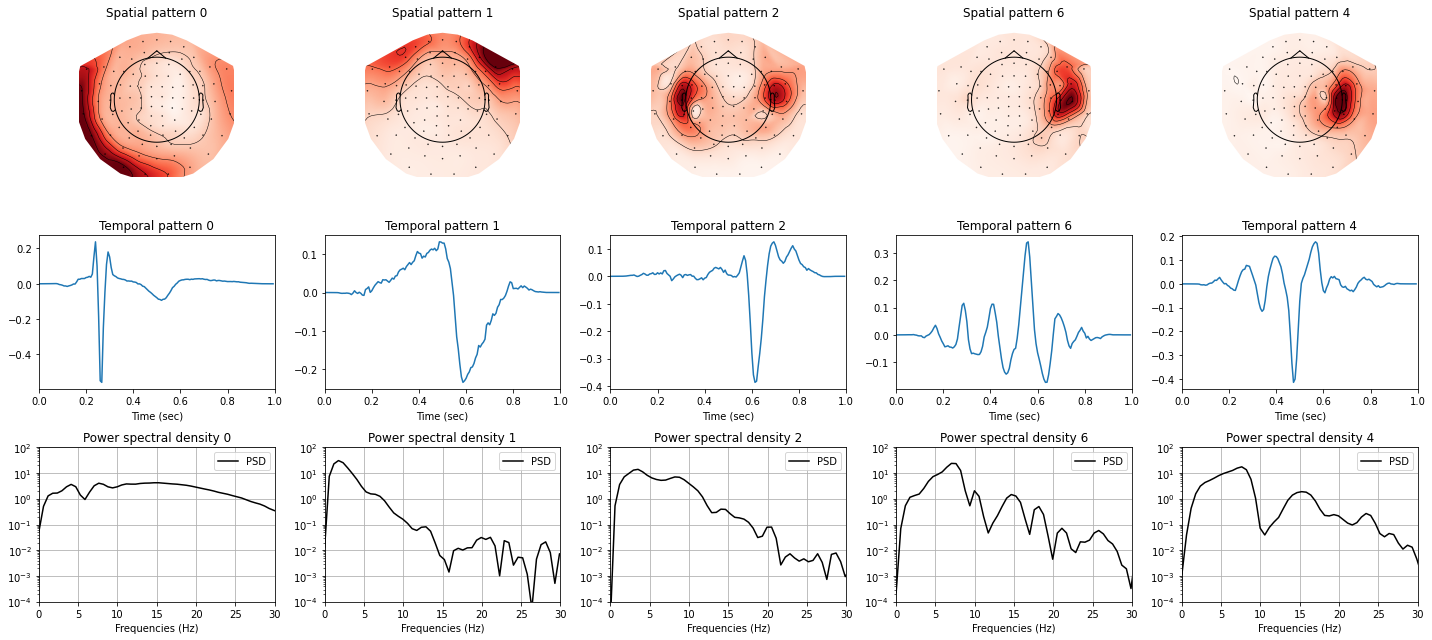

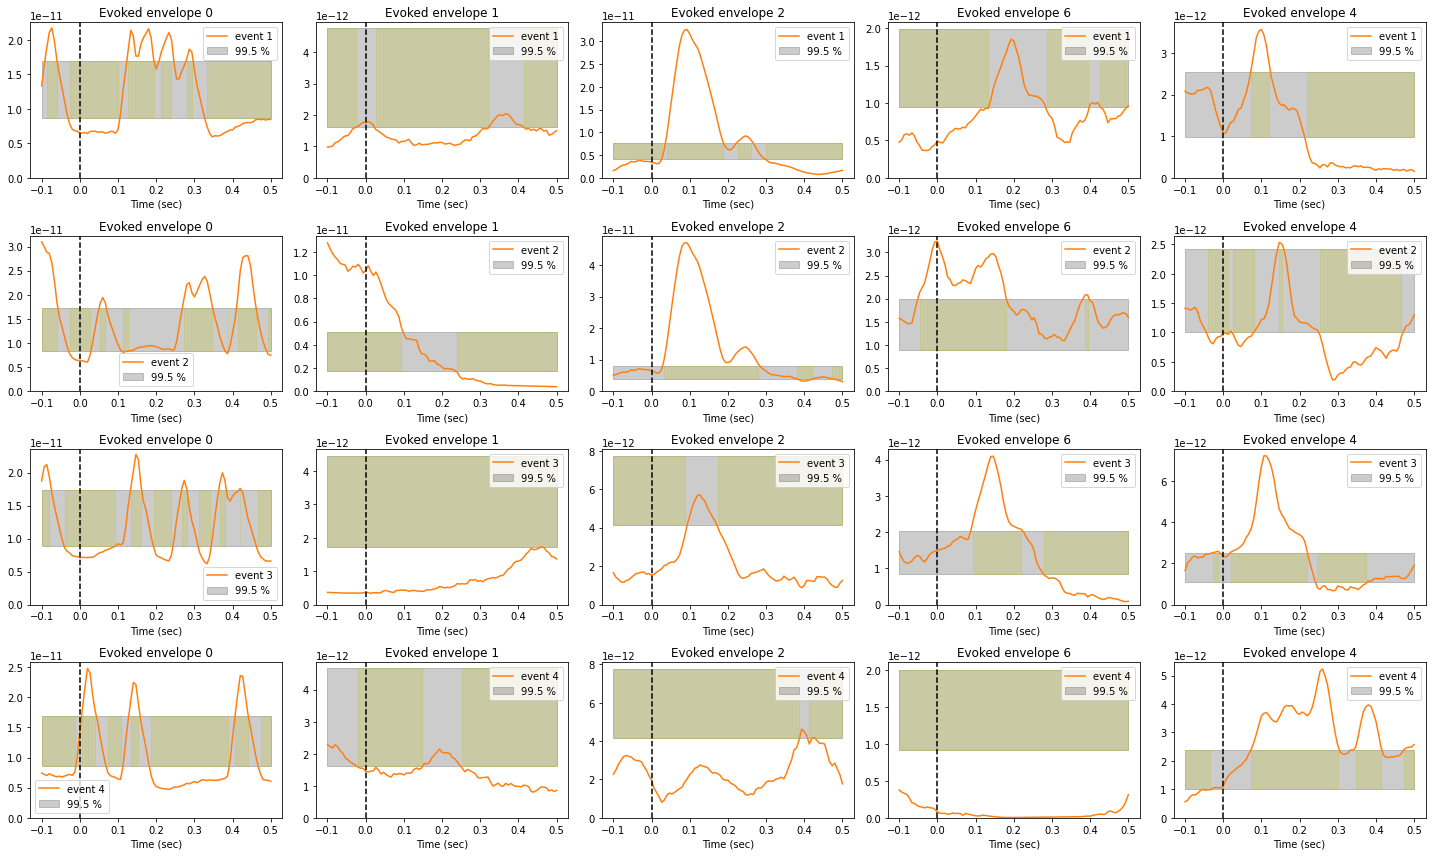

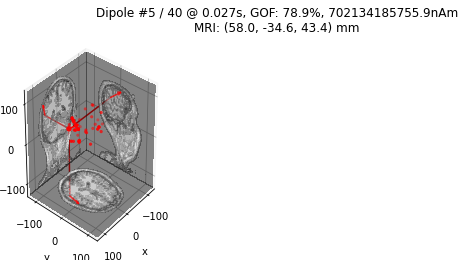

<Figure size 432x288 with 0 Axes>

In [ ]:
plotted_atoms = [0, 1, 2, 6, 4]
plot_learned_atoms(cdl, plotted_atoms)
event_id = [1, 2, 3, 4]
plot_envoked(cdl, z_hat, plotted_atoms, event_id)
display_dipole()

**Fit LGCD model with rank_1 dropped**

.......................

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


..................
[GreedyCDL] Converged after 41 iteration, (dz, du) = 2.775e-05, 6.717e-05
[GreedyCDL] Fit in 4465.6s
Refitting the activation to avoid amplitude bias...done
Displayed 5 atoms
319 events found
Event IDs: [ 1  2  3  4  5 32]
Displaying 0-th atom envelopeUsing data from preloaded Raw for 72 events and 91 original time points ...
63 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
64 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
64 bad epochs dropped
Using data from preloaded Raw for 70 events and 91 original time points ...
63 bad epochs dropped
Displaying 1-th atom envelopeUsing data from preloaded Raw for 72 events and 91 original time points ...
63 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
64 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
64 bad epochs dropped
Using data fro

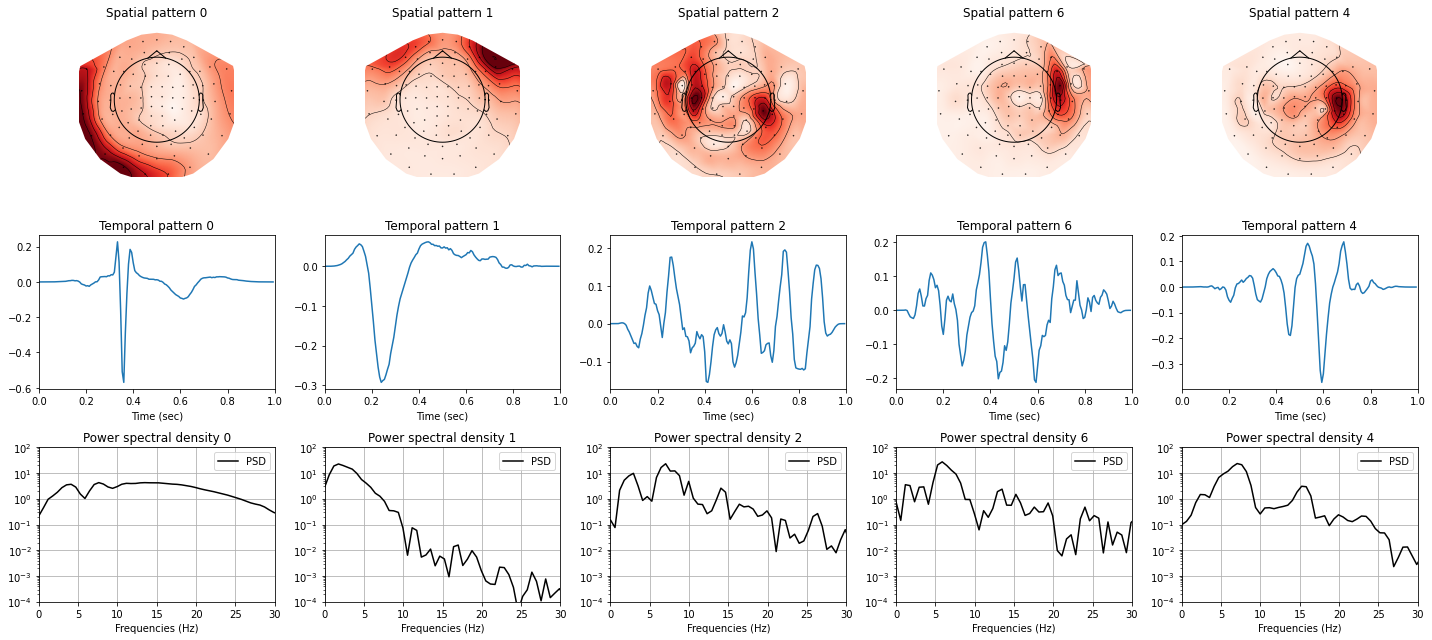

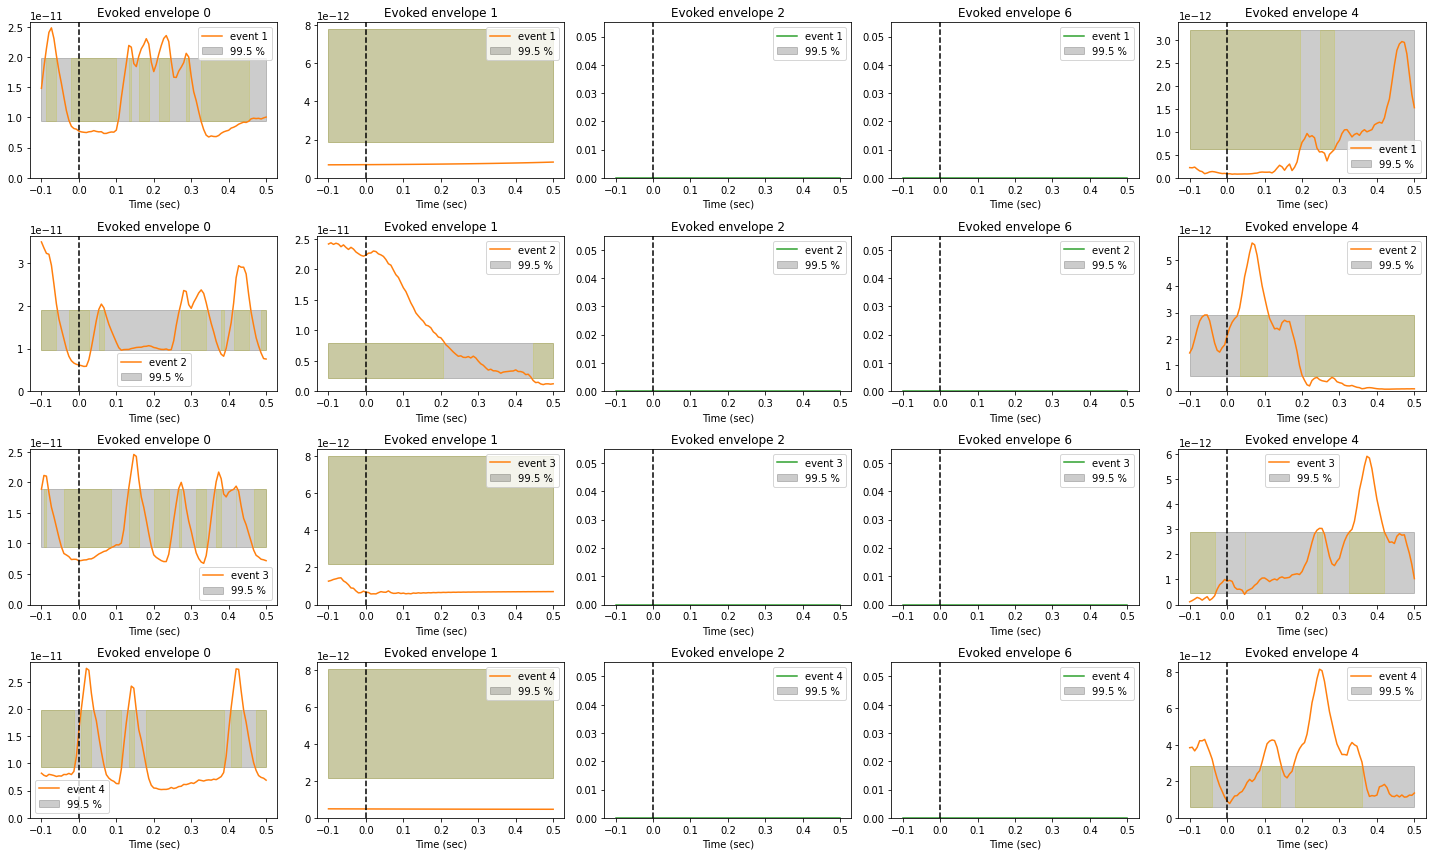

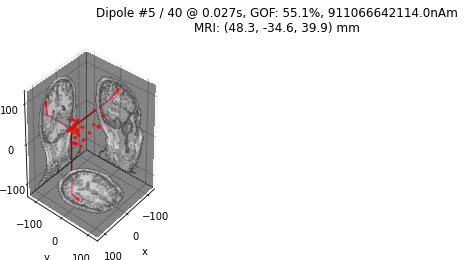

<Figure size 432x288 with 0 Axes>

In [ ]:
cdl = GreedyCdl(False)
cdl.fit(X_split)
z_hat = cdl.transform(X_split)
plotted_atoms = [0, 1, 2, 6, 4]
plot_learned_atoms(cdl, plotted_atoms)
event_id = [1, 2, 3, 4]
plot_envoked(cdl, z_hat, plotted_atoms, event_id)
display_dipole()